## Data Pre-Processing - Metop B Data

### Workflow Outline




**Repackaging step:**
Strip out sst, lat, long, wind etc.
Re-package based on per-pixel designation
Augment the point locaiton with the solar/lunar information as well using {astral}

Georgy Request
total accounting on 100x100 grid of the total number of satellite observations


In [1]:
# Libraries
import xarray as xr
import os
import L3List as L3
import pandas as pd
import datetime
import astral
import h5netcdf
import numpy as np
from tqdm import tqdm
import matplotlib

# Access AWS Credentials from netcr file
s3sys = L3.init_S3FileSystem()

## Access L2 Granules with S3List

Thanks to Nikki & Shanice we are able to locate s3 granules using a lookup class. Using that code, we can discover granules for PODAAC resources using their short_name documentation, a temporal range, and a bbox for further limiting spatial coverage.



In [2]:
# Required data 
short_name = 'AVHRRF_MC-STAR-L2P-v2.80'
provider   = 'POCLOUD'
start_date = '2022-07-01T00:00:00Z'
end_date   = '2022-10-31T23:59:59Z'
temporal_range = f'{start_date},{end_date}'
bbox = "-40,0,-35,5" #WSEN

metopb_s3 = L3.S3List()
granule_urls = metopb_s3.login_and_run_query(short_name, provider, temporal_range, bbox)
granule_urls[0:3]

['s3://podaac-ops-cumulus-protected/AVHRRF_MC-STAR-L2P-v2.80/2022/182/20220701003000-STAR-L2P_GHRSST-SSTsubskin-AVHRRF_MC-ACSPO_V2.80-v02.0-fv01.0.nc',
 's3://podaac-ops-cumulus-protected/AVHRRF_MC-STAR-L2P-v2.80/2022/182/20220701113000-STAR-L2P_GHRSST-SSTsubskin-AVHRRF_MC-ACSPO_V2.80-v02.0-fv01.0.nc',
 's3://podaac-ops-cumulus-protected/AVHRRF_MC-STAR-L2P-v2.80/2022/182/20220701131000-STAR-L2P_GHRSST-SSTsubskin-AVHRRF_MC-ACSPO_V2.80-v02.0-fv01.0.nc']

In [3]:
# Open a tester
test_xr = xr.open_dataset(s3sys.open(granule_urls[0]))
test_xr

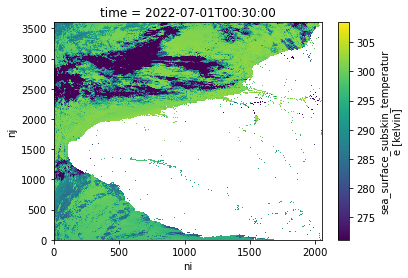

In [4]:
# Plot
test_xr.sea_surface_temperature.isel(time = 0).plot()

## Set Any Global Limits

The following controls detail the dimension and quality filtering controls that should generalize to other L2 sensor resources. These could all be abstracted out into arguments for a filtering function.

In [6]:
# SWNE Bounding Box
bbox = "-40,0,-35,5"

# Set Minimum Quality level
min_qual = 3

# Set xarray variables to discard:
discards = [
    "sses_bias", "sses_standard_deviation", "sea_ice_fraction",
    "sst_front_position", "l2p_flags", "sst_gradient_magnitude"]

## Aggregating Independent Granules

Iterate through indivudal s3 granules and subset the important variables and lat/lon/time dimensions. Combine into one aggregate xarray dataset for export or transfer to subsequent analysis pipeline steps.

These steps were adapted from `read_viirs.ipynb`

In [7]:
def clean_l2p_metop(data, qc_threshold, bbox, discards):
    """
    bbox: West,South,East,North
    """
    w, s, e, n = [int(a) for a in bbox.split(',')]
    da = data.drop_vars(discards)
    data_threshold = da.where(da.quality_level>=qc_threshold)
    all_data = data_threshold.stack(pt=('ni','nj')).dropna(dim='pt')
    loc_data = all_data.where(all_data.lat>=s).where(all_data.lat<=n).where(all_data.lon<=e).where(all_data.lon>=w)
    neat_data = loc_data.dropna(dim='pt').reset_index('pt').drop(['ni', 'nj'])
    time = neat_data.time.values
    to_return = neat_data.drop('time').squeeze()
    to_return['time'] = xr.DataArray(data=(time+to_return['sst_dtime'].values.astype('timedelta64[s]')), dims=['pt'])
    return to_return.drop_vars(['sst_dtime'])



In [8]:
# Run the cleaning function
cleaned_data = [clean_l2p_metop(xr.open_dataset(s3sys.open(url)),
                             qc_threshold = min_qual,
                             bbox = bbox,
                             discards = discards) for url in tqdm(granule_urls[0:10])]

100%|██████████| 10/10 [00:58<00:00,  5.89s/it]


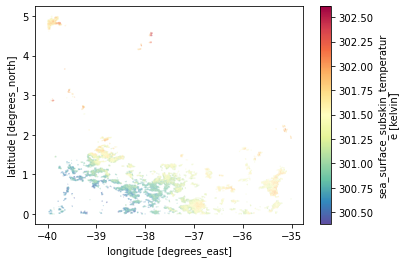

In [10]:
# Check it out:
cleaned_data[0].plot.scatter(x='lon', y='lat', hue='sea_surface_temperature', cmap='Spectral_r', s=0.01)

In [ ]:
# Concatenate the individual cleaned arrays
#cleaned_data = xr.concat(cleaned_data, dim='pt').set_coords('time').sortby('lon').sortby('lat')

---

# Alternative Data Processing - Pandas

## Conversion from Satellite Point-obs to Tabular Data

Because the satellite swaths do not overlap perfectly, they do not open together succesfully as one xarray array. To preserve the original satellite measurement locations these measurements can be converted into a tabular format and rowbinded to create a complete record.

At this point, while they are still xr.Datasets, it would be possible to easily apply a lat/lon limit to the datasets to suite project needs.

Additional steps strip away unnecessary variables for the SST analysis. Re-Packing includes 
 * sea_surface_temperature
 * quality Level (3-5)
 * l2p_flags
 * SSES_bias, 
 * SSES_standard_deviation, 
 * wind_speed
 * and others...
  
  
Coordinates: lat/lon/sst_dtime


In [10]:

# Set longitude and latitude limits of study area using xarray
lon_min = -40
lat_min = 0
lon_max = -35
lat_max = 5

# Set Minimum Quality level
min_qual = 3


# Put each file into a list as a df
granule_list = []
for url in tqdm(granule_urls[0:20]):
    
    # Open Granule
    array_s3 = s3sys.open(url) 
    
    #Load with xr
    array_i = xr.open_dataset(array_s3) 
    
    # Drop Variables We don't need
    array_i = array_i.drop(
        ["brightness_temperature_4um", "brightness_temperature_11um", "brightness_temperature_12um",
         "sses_bias", "sses_standard_deviation", "aerosol_dynamic_indicator", "adi_dtime_from_sst"])
    
    # Make it a dataframe
    df = array_i.to_dataframe()
    # Drop NA SST
    df = df.dropna(subset=['sea_surface_temperature'])
    # Drop Indexes ni, nj
    df = df.reset_index(["nj", "ni"], drop=True)
    
    # # Subset lat/lon/data_quality to suit bounds
    indexlon  = (df.lon >= lon_min) & (df.lon <= lon_max)
    indexlat  = (df.lat >= lat_min) & (df.lat <= lat_max)
    indexqual = df.quality_level >= min_qual
    
    # Subset using ^
    df = df[indexlon & indexlat & indexqual]
    
    # Add to list of all granules
    granule_list.append(df)

# Check the first one
granule_list[0].head()


,lat,lon,sea_surface_temperature,sst_dtime,dt_analysis,wind_speed,satellite_zenith_angle,l2p_flags,quality_level
time,,,,,,,,,
2022-06-30 23:10:22,0.089125,-35.003376,301.489990,1985.5,0.2,NaN,14.0,0,5.0
2022-06-30 23:10:22,0.118625,-35.009975,301.489990,1986.0,0.1,NaN,14.0,0,5.0
2022-06-30 23:10:22,0.102400,-35.081600,301.399994,1986.0,0.0,NaN,14.0,0,5.0
2022-06-30 23:10:22,0.094113,-35.118176,301.350006,1986.0,0.1,NaN,14.0,0,5.0
2022-06-30 23:10:22,0.048525,-35.455700,301.769989,1986.5,0.5,NaN,17.0,0,5.0
...,...,...,...,...,...,...,...,...,...
2022-06-30 23:10:22,1.589675,-38.722401,301.229980,2023.5,0.1,NaN,37.0,0,5.0
2022-06-30 23:10:22,1.577363,-38.776001,301.229980,2023.5,0.1,NaN,38.0,0,5.0
2022-06-30 23:10:22,1.552737,-38.883198,301.369995,2023.5,0.3,NaN,38.0,0,5.0


In [11]:
# From theat list create one mega dataframe
metops_df = pd.concat(granule_list)

# Check the Damage
metops_df.head()

,lat,lon,sea_surface_temperature,sst_dtime,dt_analysis,wind_speed,satellite_zenith_angle,l2p_flags,quality_level
time,,,,,,,,,
2022-06-30 23:10:22,0.089125,-35.003376,301.489990,1985.5,0.2,NaN,14.0,0,5.0
2022-06-30 23:10:22,0.118625,-35.009975,301.489990,1986.0,0.1,NaN,14.0,0,5.0
2022-06-30 23:10:22,0.102400,-35.081600,301.399994,1986.0,0.0,NaN,14.0,0,5.0
2022-06-30 23:10:22,0.094113,-35.118176,301.350006,1986.0,0.1,NaN,14.0,0,5.0
2022-06-30 23:10:22,0.048525,-35.455700,301.769989,1986.5,0.5,NaN,17.0,0,5.0


<AxesSubplot:xlabel='lon', ylabel='lat'>

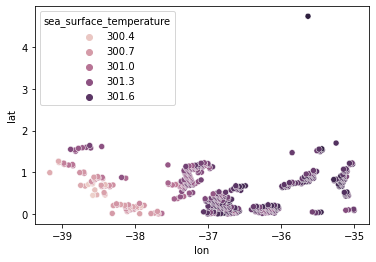

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots()
sns.scatterplot(x="lon", y="lat", hue="sea_surface_temperature", ax=ax, data=metops_df)


In [ ]:
# astral

---


---

# Deprecated Steps

### Access Downloads - PODAAC Data Downloader

Data was acquired directly from PODAAC using PODAAC Data Downloader, a command line tool. Data was downloaded using the following command in the terminal:

`podaac-data-downloader -c AVHRRMTB_G-NAVO-L2P-v2.0 -d ./l2_data/metop -sd 2018-01-13T00:00:00Z -ed 2018-01-14T00:00:00Z`

The files downloaded from PODAAC have been saved in a project sub-directory. These file names can be accessed using the {os} library to build a list of path names that could possibly be opened using `xarray.open_mfdataset()`.

In [6]:
# Path to Resource
l2_resource = "metop"
l2_path = f'../l2_data/{l2_resource}'

# Collect/Open all .nc files
metops_l = os.listdir(f"{l2_path}")
resource_files = []
for file in metops_l:
    resource_files.append(f"{l2_path}/{file}")
#resource_files[0]

# Open Single File with xarray
metop = xr.open_mfdataset(resource_files[0])
metop

<xarray.Dataset>
Dimensions:                      (nj: 6212, ni: 409, time: 1)
Coordinates:
    lat                          (nj, ni) float32 dask.array<chunksize=(6212, 409), meta=np.ndarray>
    lon                          (nj, ni) float32 dask.array<chunksize=(6212, 409), meta=np.ndarray>
  * time                         (time) datetime64[ns] 2022-10-01T16:56:52
Dimensions without coordinates: nj, ni
Data variables: (12/14)
    sea_surface_temperature      (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    sst_dtime                    (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    sses_bias                    (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    sses_standard_deviation      (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    dt_analysis                  (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    wind_speed                   (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    ...                           ...
    satellite_zenith_angle       (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    l2p_flags                    (time, nj, ni) int16 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    quality_level                (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    brightness_temperature_4um   (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    brightness_temperature_11um  (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
    brightness_temperature_12um  (time, nj, ni) float32 dask.array<chunksize=(1, 6212, 409), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                CF-1.6
    title:                      MetOpB L2P SST
    summary:                    Sea Surface temperature retrievals produced a...
    references:                 NAVOCEANO MCSST
    institution:                NAVO
    history:                    Created with fsst on  2022/10/01 at 18:15:42 UT
    ...                         ...
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             The GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L2P
    cdm_data_type:              swath

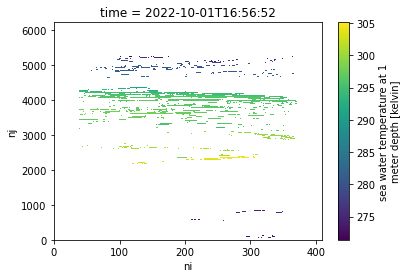

In [7]:
# Plot one
metop.sea_surface_temperature.isel(time = 0).plot()